# [TEAM-X] Anime Recommender Engine
#### NIKOLOPOULOS THOMAS 03085 - TSELOS ORFEAS-DIMITRIOS 02963
---

## Getting to know our Data

This dataset contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings.

The contents of the dataset are the following.
#### Anime.csv
\begin{itemize}
\item anime_id - myanimelist.net's unique id identifying an anime.
\item name - full name of anime.
\item genre - comma separated list of genres for this anime.
\item type - movie, TV, OVA, etc.
\item episodes - how many episodes in this show. (1 if movie).
\item rating - average rating out of 10 for this anime.
\item members - number of community members that are in this anime's "group".
\end{itemize}

#### Rating.csv
\begin{itemize}
\item user_id - non identifiable randomly generated user id.
\item anime_id - the anime that this user has rated.
\item rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).
\end{itemize}


In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.metrics.pairwise import cosine_similarity
import operator
%matplotlib inline


In [2]:
anime = pd.read_csv("input/anime.csv")
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


Shape of The Dataset : **(12294, 7)**

In [3]:
ratings = pd.read_csv("input/rating.csv")
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


Shape of The Rating Dataset : **(7813737, 3)**

In [4]:
ratings.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [5]:
anime.astype('object').describe()

,anime_id,name,genre,type,episodes,rating,members
count,12294,12294,12232,12269,12294,12064.0,12294
unique,12294,12292,3264,6,187,598.0,6706
top,32281,Shi Wan Ge Leng Xiaohua,Hentai,TV,1,6.0,72
freq,1,2,823,3787,5677,141.0,36


In [6]:
anime.describe()

,anime_id,rating,members
count,12294.000000,12064.000000,1.229400e+04
mean,14058.221653,6.473902,1.807134e+04
std,11455.294701,1.026746,5.482068e+04
min,1.000000,1.670000,5.000000e+00
25%,3484.250000,5.880000,2.250000e+02
50%,10260.500000,6.570000,1.550000e+03
75%,24794.500000,7.180000,9.437000e+03
max,34527.000000,10.000000,1.013917e+06


Due to some trial and error during the development of the project we realized that the ***ratings.csv*** dataset is missing some anime_id's and so not every anime in our ***anime.csv*** dataset has ratings.

In [7]:
print(ratings['anime_id'].nunique())
print(anime['anime_id'].nunique())

11200
12294


While this does not pose any real threat to our recommendation engine since the differene is not significant, it does mean that there will be a few Anime that we will have no way of predicting/recommmending simply because there are no records of it.

---
## Feature Cleaning - Anime Dataset

### Missing Values

In [8]:
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

*We decide to drop the missing values, because their number is too small compared to the total number of entries*

In [9]:
anime = anime.dropna()
anime.shape

(12017, 7)

In [10]:
anime.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

### Duplicate Values


In [11]:
anime.nunique()

anime_id    12017
name        12015
genre        3229
type            6
episodes      187
rating        598
members      6596
dtype: int64

*We see that there are no duplicate values*

---
## Feature Cleaning - Ratings Dataset

### Missing Values

In [12]:
ratings.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

*There are no missing values*

### Duplicate Values


In [13]:
print(ratings.shape)
ratings.duplicated().sum()

(7813737, 3)


1

*We see that there is 1 duplicate value*

In [14]:
ratings = ratings.drop_duplicates()

In [15]:
print(ratings.shape)
ratings.duplicated().sum()

(7813736, 3)


0

*Duplicate has been removed*

---
## Feature Engineering

## Top Anime with the most members

In [16]:
# Group anime by 'name' and sum the 'member' values for each name
sum_members = anime.groupby('name')['members'].sum()
# Sort names based on the sum of 'other_column' values
sum_members = sum_members.sort_values(ascending=False)

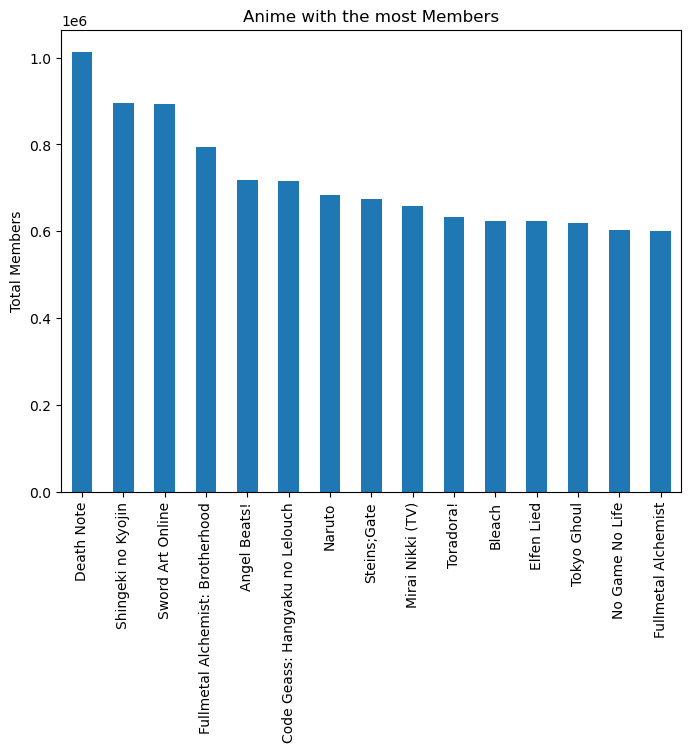

In [17]:
top15 = sum_members.head(15)
plt.figure(figsize=(8,6))
top15.plot(kind='bar')
plt.xlabel('Name')
plt.ylabel('Total Members')
plt.xlabel('')
plt.title('Anime with the most Members')
plt.show()

## Top Anime by rating

In [18]:
sort_ratings = anime.groupby('name')['rating'].sum()
sort_ratings = sort_ratings.sort_values(ascending=False)
sort_ratings.head(10)

name
Shi Wan Ge Leng Xiaohua                    13.74
Taka no Tsume 8: Yoshida-kun no X-Files    10.00
Saru Kani Gassen                            9.98
Spoon-hime no Swing Kitchen                 9.60
Mogura no Motoro                            9.50
Kimi no Na wa.                              9.37
Kahei no Umi                                9.33
Fullmetal Alchemist: Brotherhood            9.26
Yakusoku: Africa Mizu to Midori             9.25
Gintama°                                    9.25
Name: rating, dtype: float64

We see that this list is suspicious because it is different from the first 10 entries of the anime dataset. 

The anime on the anime.csv are already sorted by rating and thus the first 10 rows of the data correspond to the top 10 anime based on rating.

In [19]:
top_anime = anime[anime['rating'] >= 9.2]
top_anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
9078,33607,Kahei no Umi,Historical,Movie,1,9.33,44
9595,23005,Mogura no Motoro,Slice of Life,Movie,1,9.50,62
10400,30120,Spoon-hime no Swing Kitchen,"Adventure, Kids",TV,Unknown,9.60,47
10464,33662,Taka no Tsume 8: Yoshida-kun no X-Files,"Comedy, Parody",Movie,1,10.00,13
10786,26313,Yakusoku: Africa Mizu to Midori,"Drama, Kids",OVA,1,9.25,53


We filter based on member count so we remove outliers where their ratings are incredibly high, because very few people have rated them and so their ratings do not reflect reality.

In [20]:
top_anime = anime[anime['rating'] >= 9.2]
top_anime = top_anime[top_anime['members'] >= 100]
top_anime

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262


In [21]:
anime.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


So in order to get the top rated anime we only have to look at the anime dataset

In [22]:
top_10 = anime.head(10)
top_10 = top_10.groupby('name')['rating'].sum()
top_10 = top_10.sort_values(ascending=False)
top_10

name
Kimi no Na wa.                                               9.37
Fullmetal Alchemist: Brotherhood                             9.26
Gintama°                                                     9.25
Steins;Gate                                                  9.17
Gintama&#039;                                                9.16
Haikyuu!!: Karasuno Koukou VS Shiratorizawa Gakuen Koukou    9.15
Hunter x Hunter (2011)                                       9.13
Ginga Eiyuu Densetsu                                         9.11
Gintama&#039;: Enchousen                                     9.11
Gintama Movie: Kanketsu-hen - Yorozuya yo Eien Nare          9.10
Name: rating, dtype: float64

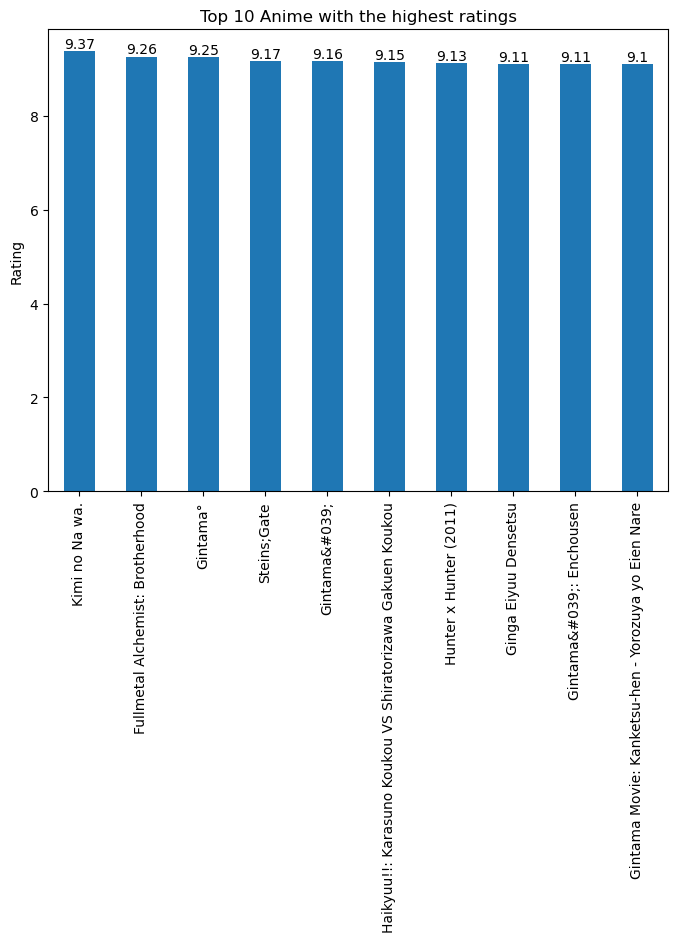

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))  # Set a larger figure size
top_10.plot(kind='bar',ax = ax,legend=False)
plt.ylabel('Rating')
plt.xlabel('')
plt.title('Top 10 Anime with the highest ratings')
# Adding ratings as annotations on top of each bar
for i, rating in enumerate(top_10):
    ax.annotate(str(rating), (i, rating), ha='center', va='bottom')
plt.show()

## Anime Types

In [24]:
anime_types = anime.groupby('type').size().sort_values(ascending=False)
anime_types

type
TV         3668
OVA        3284
Movie      2259
Special    1670
ONA         648
Music       488
dtype: int64

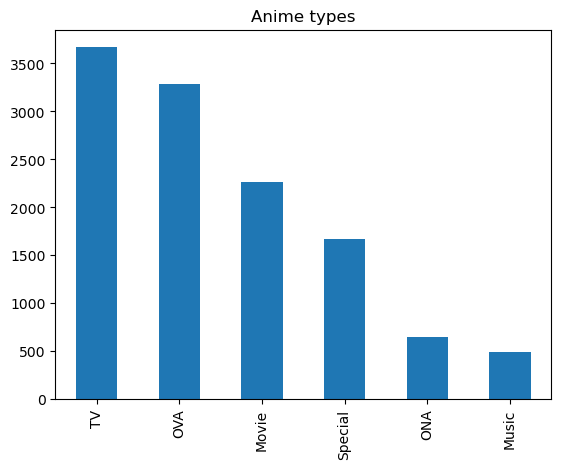

In [25]:
anime_types.plot(kind='bar')
plt.title('Anime types')
plt.xlabel('')
plt.show()

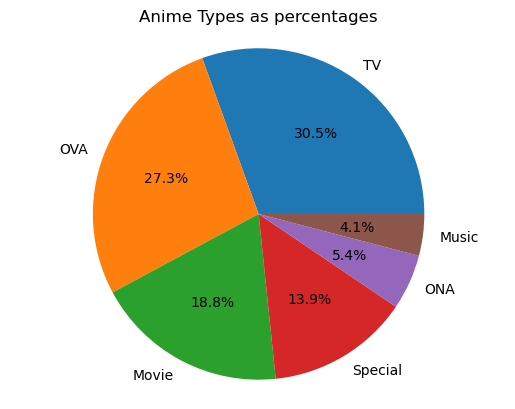

In [26]:
types_pie = anime['type'].value_counts(normalize=True)*100
plt.pie(types_pie,labels=types_pie.index, autopct='%1.1f%%')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Anime Types as percentages')
plt.show()

## Anime ratings distribution

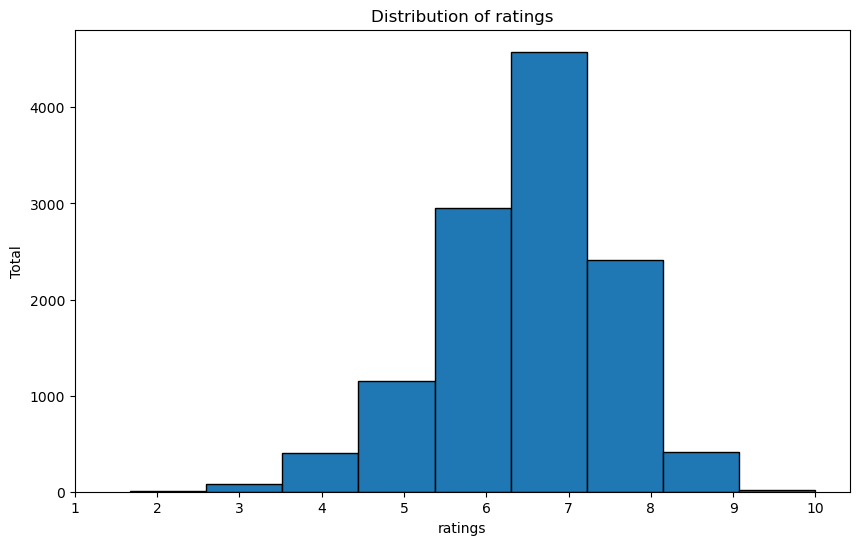

In [27]:
plt.figure(figsize=(10, 6))
anime['rating'].plot(kind='hist', bins=9,edgecolor='black')  # Adjust bins for granularity and alpha for transparency
plt.xlabel('ratings')
plt.ylabel('Total')
plt.title('Distribution of ratings')
plt.xticks(np.linspace(1,10,10))
plt.show()

In [28]:
anime['rating'].describe()

count    12017.000000
mean         6.478264
std          1.023857
min          1.670000
25%          5.890000
50%          6.570000
75%          7.180000
max         10.000000
Name: rating, dtype: float64

---
# User Based Recommendation Engine

Below we have an implementation of a recommender engine based on a specific user.
We give the algorithm a specific _user_id_ and based on his own and other similar user's watch history it recommends Anime specifically for that individual.

To achieve this we used the **Surprise** python library

## Surpsise Lib
Surprise *(Simple Python RecommendatIon System Engine)* is a Python library designed for building and evaluating recommendation systems. It provides various algorithms for collaborative filtering, matrix factorization, and other recommendation techniques. Surprise is easy to use and integrates well with scikit-learn.

In [29]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy

We first merge our two datasets, ratings and anime, so that the surprise algorithms can work with the data

In [30]:
# merge the 2 datasets: ratings and anime
mergedata = pd.merge(anime,ratings,on=['anime_id','anime_id'])
mergedata= mergedata[mergedata.user_id <= 10000] # limit the number of rows for runtime
mergedata = mergedata.drop(mergedata.columns[2:7], axis=1)
mergedata

,anime_id,name,user_id,rating_y
0,32281,Kimi no Na wa.,99,5
1,32281,Kimi no Na wa.,152,10
2,32281,Kimi no Na wa.,244,10
3,32281,Kimi no Na wa.,271,10
4,32281,Kimi no Na wa.,278,-1
...,...,...,...,...
7813468,5589,Offside Girl,3152,1
7813486,4310,Joshidai: Ecchi Soudanshitsu,6268,-1
7813487,4310,Joshidai: Ecchi Soudanshitsu,7997,-1
7813505,5569,Tsui no Sora,5204,1


In [31]:
anime_data = mergedata

The Reader class in the Surprise library is used to parse the data from a dataset, and it allows you to specify the rating scale of the dataset. The rating_scale parameter is used to define the minimum and maximum values that the ratings can take.

In [32]:
reader = Reader(rating_scale=(1, 10))
# Load the data into a Surprise Dataset
data = Dataset.load_from_df(anime_data[['user_id', 'anime_id', 'rating_y']], reader)

SVD is a matrix factorization technique used for collaborative filtering. The Surprise library provides an implementation of this algorithm.

We chose to use SVD because it offers really good run time and at the same time gives good recommendations.


In [33]:
# Split the data into training and testing sets
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

model = SVD(random_state=69) # Set seed so we get the same results each time
model.fit(trainset)

# Make predictions on the test set
predictions = model.test(testset)

In [34]:
# Evaluate the model
accuracy.rmse(predictions)
accuracy.mae(predictions)

RMSE: 2.2419
MAE:  1.5790


1.5790482156963939

In [35]:
# Function to get anime recommendations for a given user and anime name
def get_user_recommendations(user_id, anime_name):
    # Find the id of the anime given (case-insensitive)
    anime_id = anime_data.loc[anime_data['name'].str.contains(anime_name, case=False), 'anime_id'].iloc[0]

    # Get anime the user has not rated
    unrated_anime = anime_data.loc[~((anime_data['user_id'] == user_id) & (anime_data['anime_id'] == anime_id))]

    # Create a list of tuples (anime_id, estimated_rating) for the user
    user_anime_ratings = [(anime_id, model.predict(user_id, anime_id).est) for anime_id in unrated_anime['anime_id'].unique()]

    # Sort the recommendations by estimated rating in descending order
    user_anime_ratings.sort(key=lambda x: x[1], reverse=True)

    # Get the top 5 recommended anime names
    recommended_anime_names = [anime_data.loc[anime_data['anime_id'] == anime_id, 'name'].iloc[0] for anime_id, _ in user_anime_ratings[:5]]

    # Print the Shows and their ratings
    count = 1
    print('Top 5 Shows for user:{} based on {}:\n'.format(user_id,anime_name))
    for item in recommended_anime_names:
        print('{}: {} {}'.format(count, item,anime[anime['name'] == item].rating.values))
        count +=1  

In [54]:
user_id = 12
name = "Death Note"
get_user_recommendations(user_id,name)

Top 5 Shows for user:12 based on Death Note:

1: Code Geass: Hangyaku no Lelouch R2 [8.98]
2: Rainbow: Nisha Rokubou no Shichinin [8.64]
3: Steins;Gate [9.17]
4: Shingeki no Kyojin [8.54]
5: Hunter x Hunter [8.48]


---
# Implementation with Cosine Similarity

By deafault the ratings dataset uses '-1' to represent missing ratings. We will be replacing these values with NaN so we can normalize the data and use cosine similarity in order to create our recommender system.

In [55]:
ratings.replace({-1: np.nan}, regex=True, inplace = True)
ratings

,user_id,anime_id,rating
0,1,20,NaN
1,1,24,NaN
2,1,79,NaN
3,1,226,NaN
4,1,241,NaN
...,...,...,...
7813732,73515,16512,7.0
7813733,73515,17187,9.0
7813734,73515,22145,10.0
7813735,73516,790,9.0


Here we are chosing to include only the TV-Shows and not any movies, because the TV-Shows are more well known and thus we can present a better example.
Obviously we could use every Anime and the algorithm would run just as well.

In [56]:
anime_tv = anime[anime['type']=='TV']
# anime_tv = anime
anime_tv

,anime_id,name,genre,type,episodes,rating,members
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
...,...,...,...,...,...,...,...
10879,31698,Zhan Long Si Qu,"Cars, Kids",TV,64,4.80,67
10882,31427,Zinba,"Action, Adventure, Comedy, Demons, Magic, Supe...",TV,52,7.17,172
10889,13167,Zoobles!,Kids,TV,26,5.57,109
10892,7808,Zukkoke Knight: Don De La Mancha,"Adventure, Comedy, Historical, Romance",TV,23,6.47,172


In [57]:
# Merge the 2 datasets in order to use the algorithms later
mergedata = ratings.merge(anime_tv, left_on = 'anime_id', right_on = 'anime_id')
mergedata.rename(columns = {'rating_x':'user_rating','rating_y':'rating'}, inplace = True)
mergedata

,user_id,anime_id,user_rating,name,genre,type,episodes,rating,members
0,1,20,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
1,3,20,8.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
2,5,20,6.0,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,6,20,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
4,10,20,NaN,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
...,...,...,...,...,...,...,...,...,...
5283590,53492,31071,3.0,"Kinyoru, Abe Reiji: Heikinteki na Salaryman no...",Comedy,TV,5,4.14,234
5283591,53492,31177,4.0,Yakyuubu Aruaru,Sports,TV,3,4.00,149
5283592,53492,31237,5.0,Ganbare-bu Next!,"Comedy, Sports",TV,6,5.36,70
5283593,53492,31464,3.0,Pichiko Dakyuubu,"Comedy, Sports",TV,29,5.00,39


In [58]:
# these are the only columns we need
mergedata=mergedata[['user_id', 'name', 'user_rating']]
mergedata= mergedata[mergedata.user_id <= 3000] # limit the number of rows for runtime improvement
mergedata

,user_id,name,user_rating
0,1,Naruto,NaN
1,3,Naruto,8.0
2,5,Naruto,6.0
3,6,Naruto,NaN
4,10,Naruto,NaN
...,...,...,...
5271262,2918,Dallyeola Hani,9.0
5271267,2951,Moonlight Mile 1st Season: Lift Off,8.0
5271450,2951,Moonlight Mile 2nd Season: Touch Down,8.0
5271537,2951,Kara The Animation,8.0


In order to use cosine simalirty to find all the similarities between the anime shows we have to pivot our Data so our user ratings are on the columns and the anime names on the rows.

In [59]:
data = mergedata.pivot_table(index=['name'], columns=['user_id'], values='user_rating')
data

user_id,1,2,3,5,7,8,9,10,11,12,...,2989,2990,2991,2992,2993,2994,2995,2996,2998,2999
name,,,,,,,,,,,,,,,,,,,,,
.hack//Roots,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
.hack//Sign,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
.hack//Tasogare no Udewa Densetsu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
009-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07-Ghost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gdgd Fairies 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iDOLM@STER Xenoglossia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s.CRY.ed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Here we are normalizing our data so we can work with them.
So, after this operation, each column will be normalized using Min-Max scaling based on its own mean, minimum, and maximum values.

Keep in mind that Min-Max scaling squeezes the values of each row to a range between 0 and 1.

In [60]:
# all users with only one rating or who had rated everything the same will be 0
data = data.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=0)
data

user_id,1,2,3,5,7,8,9,10,11,12,...,2989,2990,2991,2992,2993,2994,2995,2996,2998,2999
name,,,,,,,,,,,,,,,,,,,,,
.hack//Roots,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
.hack//Sign,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
.hack//Tasogare no Udewa Densetsu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
009-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07-Ghost,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gdgd Fairies 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iDOLM@STER Xenoglossia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s.CRY.ed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We drop all users who did not rate anything to cut down on computational costs.

In [61]:
data.fillna(0, inplace=True)
data = data.loc[:, (data != 0).any(axis=0)]
data

user_id,3,5,7,8,10,11,12,14,16,17,...,2989,2990,2991,2992,2993,2994,2995,2996,2998,2999
name,,,,,,,,,,,,,,,,,,,,,
.hack//Roots,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Sign,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Tasogare no Udewa Densetsu,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
009-1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
07-Ghost,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gdgd Fairies 2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.099164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
iDOLM@STER Xenoglossia,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s.CRY.ed,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Moreover we are transforming our matrix to a sparse matrix representation.
This can be particularly useful when working with large datasets where most of the values are 0, as it saves memory compared to storing the entire dense matrix.
Also certain algorithms and libraries, such as Scikit-learn, can handle sparse matrices more efficiently and thus, imnprove our computational time.

In [62]:
data_sparse = sp.sparse.csr_matrix(data.values)

In [63]:
# Compute all the similarities between the anime names based on user ratings
anime_similarity = cosine_similarity(data_sparse)

# Inserting the similarity matricies into dataframe objects
anime_sim_df = pd.DataFrame(anime_similarity, index = data.index, columns = data.index)
anime_sim_df

name,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,009-1,07-Ghost,11eyes,12-sai.: Chicchana Mune no Tokimeki,3 Choume no Tama: Uchi no Tama Shirimasenka?,30-sai no Hoken Taiiku,91 Days,...,Zombie-Loan,Zukkoke Knight: Don De La Mancha,ef: A Tale of Melodies.,ef: A Tale of Memories.,gdgd Fairies,gdgd Fairies 2,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei
name,,,,,,,,,,,,,,,,,,,,,
.hack//Roots,1.000000,0.221592,0.280241,-0.062339,0.050119,0.005539,0.000000,0.000000,0.105405,-0.063973,...,0.045173,0.0,-0.009200,0.005999,0.000000,0.000000,-0.002319,0.025887,0.015016,-0.010330
.hack//Sign,0.221592,1.000000,0.283246,0.086160,0.047388,0.021872,0.000000,0.000000,0.048897,-0.070921,...,-0.002167,0.0,-0.003586,-0.007802,0.000000,0.000000,-0.003869,0.076224,0.032013,-0.025110
.hack//Tasogare no Udewa Densetsu,0.280241,0.283246,1.000000,0.262065,0.029278,0.008328,0.000000,0.000000,0.011485,-0.018164,...,0.102779,0.0,-0.023169,-0.024906,0.000000,0.000000,0.000285,0.033147,-0.001845,0.011299
009-1,-0.062339,0.086160,0.262065,1.000000,-0.026273,0.013174,0.000000,0.000000,0.000000,0.000000,...,0.004628,0.0,0.041600,0.040542,0.000000,0.000000,0.000000,0.000000,0.042527,0.060531
07-Ghost,0.050119,0.047388,0.029278,-0.026273,1.000000,0.135311,0.004813,-0.017066,0.110150,-0.066043,...,0.094195,0.0,0.010992,-0.007877,0.000176,0.000115,0.003821,0.014461,0.003449,-0.021216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gdgd Fairies 2,0.000000,0.000000,0.000000,0.000000,0.000115,0.001426,0.000000,0.000000,0.000000,-0.020977,...,-0.001606,0.0,0.001709,-0.013532,0.030137,1.000000,-0.004143,0.000000,0.000000,0.000000
iDOLM@STER Xenoglossia,-0.002319,-0.003869,0.000285,0.000000,0.003821,-0.003287,0.000000,0.000000,0.000000,-0.027847,...,0.013212,0.0,-0.012239,-0.006297,-0.006322,-0.004143,1.000000,0.000000,-0.071872,0.006741
s.CRY.ed,0.025887,0.076224,0.033147,0.000000,0.014461,-0.006955,0.000000,0.000000,0.016736,-0.009069,...,0.002273,0.0,0.000268,0.000406,0.000000,0.000000,0.000000,1.000000,-0.016026,-0.037875


In [64]:
# This function will return the top 10 shows with the highest cosine similarity value
def recommend_anime(name):
    count = 1
    print('Top 10 Shows based on {}:\n'.format(name))
    for item in anime_sim_df.sort_values(by = name, ascending = False).index[1:11]:
        print('{}: {} {}'.format(count, item,anime[anime['name'] == item].rating.values))
        count +=1  

In [66]:
recommend_anime('Death Note')

Top 10 Shows based on Death Note:

1: Code Geass: Hangyaku no Lelouch R2 [8.98]
2: Code Geass: Hangyaku no Lelouch [8.83]
3: Shingeki no Kyojin [8.54]
4: Fullmetal Alchemist: Brotherhood [9.26]
5: Steins;Gate [9.17]
6: Hunter x Hunter (2011) [9.13]
7: One Punch Man [8.82]
8: Kiseijuu: Sei no Kakuritsu [8.59]
9: Boku dake ga Inai Machi [8.65]
10: Great Teacher Onizuka [8.77]


---